# RUNE: A Complete Interpretation Showcase

This notebook serves as a comprehensive tutorial and demonstration for every function within the `rune.interpret` module. We will first train a suite of representative models from the `rune` library, including variants that use different pairwise interaction types (`difference`, `log_ratio`, `ratio`). Then, we will use these trained models to showcase each interpretation tool, explaining its purpose and how to read the output.

**Goal:** To provide a clear, practical example for every public interpretation function available in the `rune` library, highlighting the differences in interpretation for various model architectures.

**Models to be Interpreted:**
1.  `InterpretableRuneNet` (with `difference`, `log_ratio`, and `ratio` interactions)
2.  `PrototypeRuneNet`: The case-based reasoning model.
3.  `PairwiseDifferenceNet`: A simpler model to showcase specific layer visualizations.
4.  `CyclicTropicalDifferenceNet`: To demonstrate its unique projection layer visualization.

In [1]:
!pip install git+https://github.com/EmotionEngineer/rune.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.6 MB/s eta 0:00:00


In [2]:
# ==============================================================================
# Section 1: Setup and Library Imports
# ==============================================================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_wine
import json
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Environment Setup
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
sns.set_theme(style="whitegrid")

# --- Import from the RUNE library ---
try:
    from rune.models import (
        InterpretableRuneNet,
        PrototypeRuneNet,
        PairwiseDifferenceNet,
        CyclicTropicalDifferenceNet
    )
    from rune.interpret import (
        plot_pairwise_difference_weights,
        plot_tropical_aggregator_params,
        plot_gated_aggregator_gates,
        plot_linear_weights,
        plot_cyclic_layer_projection_weights,
        plot_feature_interaction_graph,
        plot_final_layer_contributions,
        analyze_tropical_dominance,
        trace_decision_path,
        analyze_prototype_prediction,
        plot_prototypes_with_tsne,
    )
except ImportError as e:
    raise ImportError(f"Could not import from rune. Please install it first:\n!pip install git+https://github.com/EmotionEngineer/rune.git\nOriginal error: {e}")

# Global Configurations
LEARNING_RATE = 0.001
EPOCHS = 2000 # Reduced for a faster showcase
BATCH_SIZE = 32
PATIENCE = 300
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Section 2: Training Infrastructure
This section contains the necessary functions to load data and train our models. These trained models will serve as the subjects for our interpretation deep-dive.

In [3]:
def get_data(scaler_type='standard'):
    """
    Loads and prepares the wine dataset.
    scaler_type: 'standard' for StandardScaler or 'minmax' for MinMaxScaler.
    'minmax' is required for 'log_ratio' and 'ratio' models to ensure positive inputs.
    """
    data = load_wine()
    X, y, feature_names = data.data, data.target, data.feature_names

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    if scaler_type == 'minmax':
        # Ensure the feature range is strictly positive
        scaler = MinMaxScaler(feature_range=(0.01, 1)).fit(X_train_raw)
    else:
        scaler = StandardScaler().fit(X_train_raw)

    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))

    input_dim = X.shape[1]
    output_dim = len(set(y))

    return DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True), (X_test, y_test), scaler, feature_names, input_dim, output_dim

def train_model(model, train_loader, epochs=EPOCHS, patience=PATIENCE):
    """Trains a given model with early stopping."""
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}", leave=False):
        model.train()
        current_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            
            # Add L1 regularization if the model supports it
            if hasattr(model, 'get_regularization_loss'):
                loss += 1e-4 * model.get_regularization_loss()
                
            loss.backward()
            optimizer.step()
            current_loss += loss.item()

        avg_loss = current_loss / len(train_loader)

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.eval()
    return model

## Section 3: Model Training
We train a variety of models, including three `InterpretableRuneNet` variants with different interaction types, to serve as subjects for our interpretation showcase.

In [4]:
# 1. Data for models using 'difference' interaction (standard scaled)
train_loader_std, (X_test_std, y_test_std), _, feature_names, input_dim, output_dim = get_data(scaler_type='standard')

# 2. Data for models using 'log_ratio' or 'ratio' interactions (strictly positive)
train_loader_pos, (X_test_pos, y_test_pos), _, _, _, _ = get_data(scaler_type='minmax')

print("--- Training Models for Interpretation Showcase ---")
base_kwargs = {"input_dim": input_dim, "output_dim": output_dim, "num_blocks": 2, "block_dim": 16}

# --- InterpretableRuneNet Variants ---
irn_model_diff = train_model(InterpretableRuneNet(**base_kwargs, interaction_type='difference'), train_loader_std)
irn_model_log_ratio = train_model(InterpretableRuneNet(**base_kwargs, interaction_type='log_ratio'), train_loader_pos)
irn_model_ratio = train_model(InterpretableRuneNet(**base_kwargs, interaction_type='ratio'), train_loader_pos)

# --- Other Models ---
# For PrototypeRuneNet, 'log_ratio' is a great fit since distances are always positive.
proto_model = train_model(PrototypeRuneNet(input_dim=input_dim, output_dim=output_dim, num_prototypes=8, interaction_type='log_ratio'), train_loader_std)
pdn_model = train_model(PairwiseDifferenceNet(input_dim=input_dim, output_dim=output_dim, interpretable_head=True), train_loader_std)
ctdn_model = train_model(CyclicTropicalDifferenceNet(input_dim=input_dim, output_dim=output_dim, interpretable_head=True), train_loader_std)

print("--- All models trained ---")

--- Training Models for Interpretation Showcase ---


Training InterpretableRuneNet:   0%|          | 0/2000 [00:00<?, ?it/s]

Training InterpretableRuneNet:   0%|          | 0/2000 [00:00<?, ?it/s]

Training InterpretableRuneNet:   0%|          | 0/2000 [00:00<?, ?it/s]

Training PrototypeRuneNet:   0%|          | 0/2000 [00:00<?, ?it/s]

Training PairwiseDifferenceNet:   0%|          | 0/2000 [00:00<?, ?it/s]

Training CyclicTropicalDifferenceNet:   0%|          | 0/2000 [00:00<?, ?it/s]

--- All models trained ---


## Section 4: Complete Interpret
In this section, we will call every major function from the `rune.interpret` module, using the models we just trained. Each subsection will explain the function's purpose and show its output.

### 4.1. Visualizing Simple Layer Weights
These functions inspect the parameters of individual, basic layers.

#### `plot_linear_weights`

Visualizes the weight matrix of any `nn.Linear` layer. Here, we inspect the input projection layer of our `InterpretableRuneNet`, showing how original features are mapped into the model's hidden space.

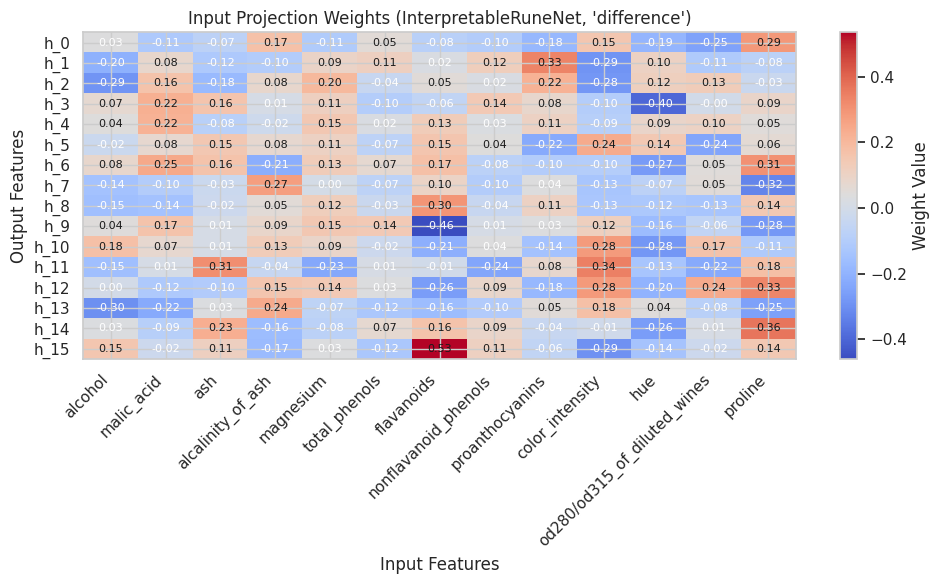

In [5]:
display(Markdown("#### `plot_linear_weights`"))
display(Markdown("Visualizes the weight matrix of any `nn.Linear` layer. Here, we inspect the input projection layer of our `InterpretableRuneNet`, showing how original features are mapped into the model's hidden space."))

fig, ax = plt.subplots(figsize=(10, 6))
plot_linear_weights(
    irn_model_diff.input_projection,
    feature_names_in=feature_names,
    feature_names_out=[f"h_{i}" for i in range(irn_model_diff.input_projection.out_features)],
    ax=ax,
    title="Input Projection Weights (InterpretableRuneNet, 'difference')"
)
plt.show()

#### `plot_pairwise_difference_weights`

Shows the learned importance of each `(feature_i - feature_j)` comparison in a `PairwiseDifferenceLayer`. This is useful for simple models that use this explicit feature engineering step.

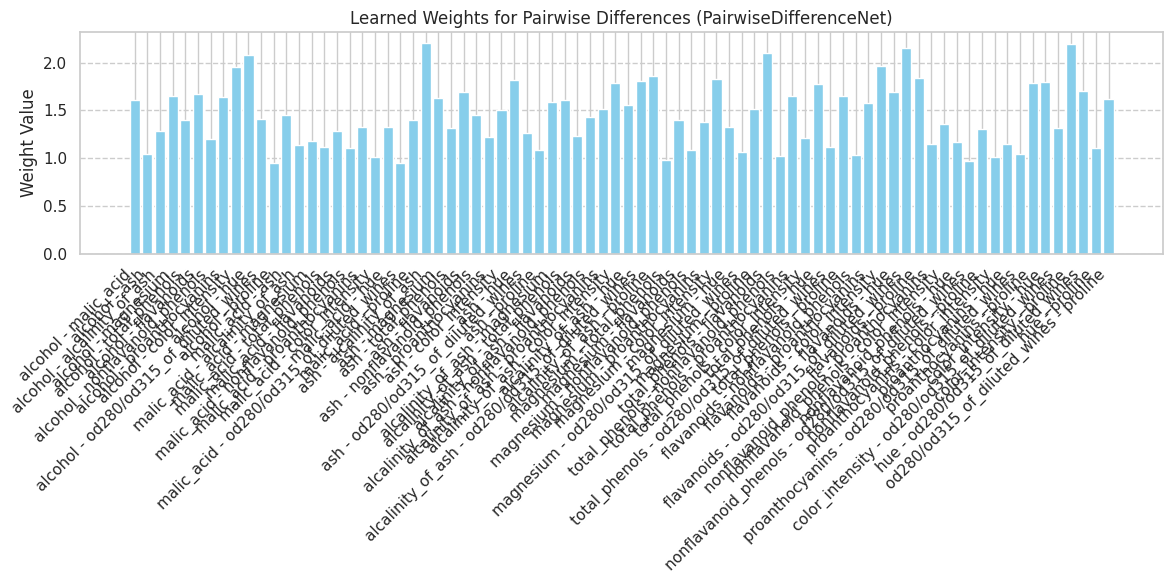

In [6]:
display(Markdown("#### `plot_pairwise_difference_weights`"))
display(Markdown("Shows the learned importance of each `(feature_i - feature_j)` comparison in a `PairwiseDifferenceLayer`. This is useful for simple models that use this explicit feature engineering step."))

fig, ax = plt.subplots(figsize=(12, 6))
plot_pairwise_difference_weights(
    pdn_model.pairwise_diff_layer,
    feature_names=feature_names,
    ax=ax,
    title="Learned Weights for Pairwise Differences (PairwiseDifferenceNet)"
)
plt.show()

#### `plot_cyclic_layer_projection_weights`

A convenience wrapper for `plot_linear_weights`, specifically for the projection layer inside a `CyclicTropicalDifferenceLayer`.

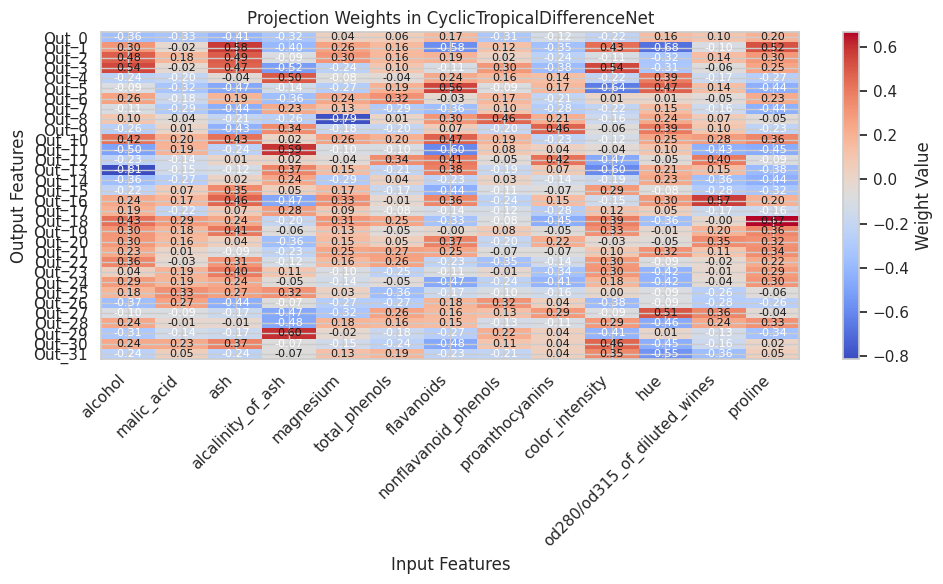

In [7]:
display(Markdown("#### `plot_cyclic_layer_projection_weights`"))
display(Markdown("A convenience wrapper for `plot_linear_weights`, specifically for the projection layer inside a `CyclicTropicalDifferenceLayer`."))

fig, ax = plt.subplots(figsize=(10, 6))
plot_cyclic_layer_projection_weights(
    ctdn_model.cyclic_tropical_diff_layer,
    feature_names_in=feature_names,
    title="Projection Weights in CyclicTropicalDifferenceNet",
    ax=ax
)
plt.show()

### 4.2. Deconstructing RUNE Blocks
These functions allow us to look inside the core components of `InterpretableRuneNet`.

#### `plot_tropical_aggregator_params`

Visualizes the key interaction weights (`W_ij`) inside a `TropicalDifferenceAggregator`. This heatmap reveals which pairwise comparisons of hidden features the model relies on most heavily.

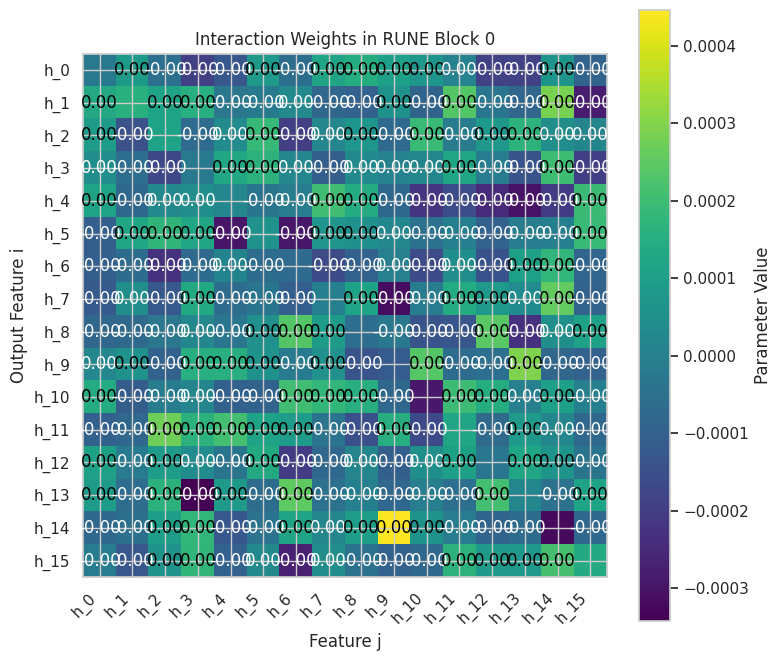

In [8]:
display(Markdown("#### `plot_tropical_aggregator_params`"))
display(Markdown("Visualizes the key interaction weights (`W_ij`) inside a `TropicalDifferenceAggregator`. This heatmap reveals which pairwise comparisons of hidden features the model relies on most heavily."))

# Let's inspect the first RUNE block in our trained InterpretableRuneNet
block0 = irn_model_diff.rune_blocks[0]
hidden_dim = block0.gated_agg.dim
hidden_names = [f'h_{i}' for i in range(hidden_dim)]

fig, ax = plt.subplots(figsize=(8, 7))
plot_tropical_aggregator_params(
    block0.gated_agg.tropical_agg,
    feature_names=hidden_names,
    ax=ax,
    title="Interaction Weights in RUNE Block 0"
)
plt.show()

#### `plot_gated_aggregator_gates`

For a `GatedTropicalDifferenceAggregator`, this shows the learned preference between sparse, rule-based logic (tropical `max`) and holistic, averaging logic (`mean`). A value close to 1 means the model prefers the tropical rule for that hidden feature.

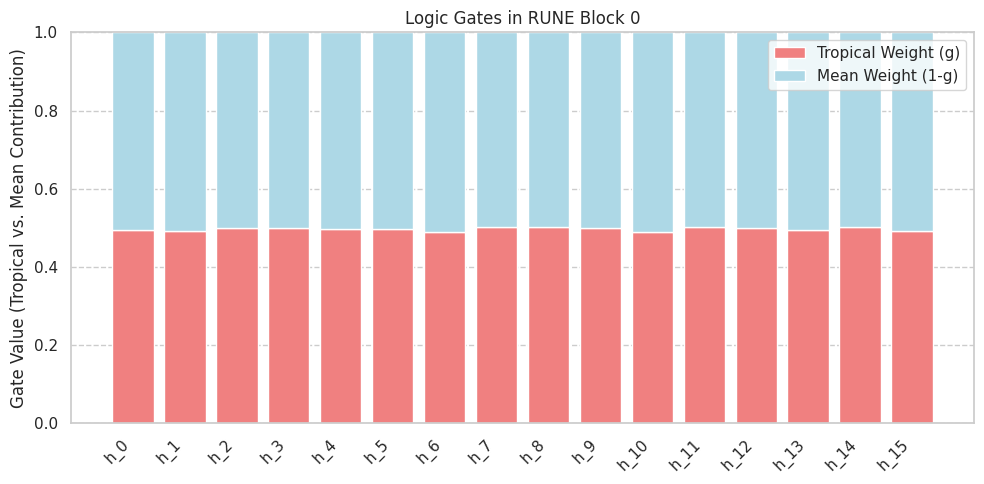

In [9]:
display(Markdown("#### `plot_gated_aggregator_gates`"))
display(Markdown("For a `GatedTropicalDifferenceAggregator`, this shows the learned preference between sparse, rule-based logic (tropical `max`) and holistic, averaging logic (`mean`). A value close to 1 means the model prefers the tropical rule for that hidden feature."))

fig, ax = plt.subplots(figsize=(10, 5))
plot_gated_aggregator_gates(
    block0.gated_agg,
    feature_names=hidden_names,
    ax=ax,
    title="Logic Gates in RUNE Block 0"
)
plt.show()

### 4.3. High-Level and Holistic Interpretation
These functions provide a bigger-picture view of the model's behavior.

#### `plot_feature_interaction_graph`

Creates a graph where nodes are input features and edges represent an important learned comparison. This provides a clear, high-level map of the model's logic. Requires `networkx`.

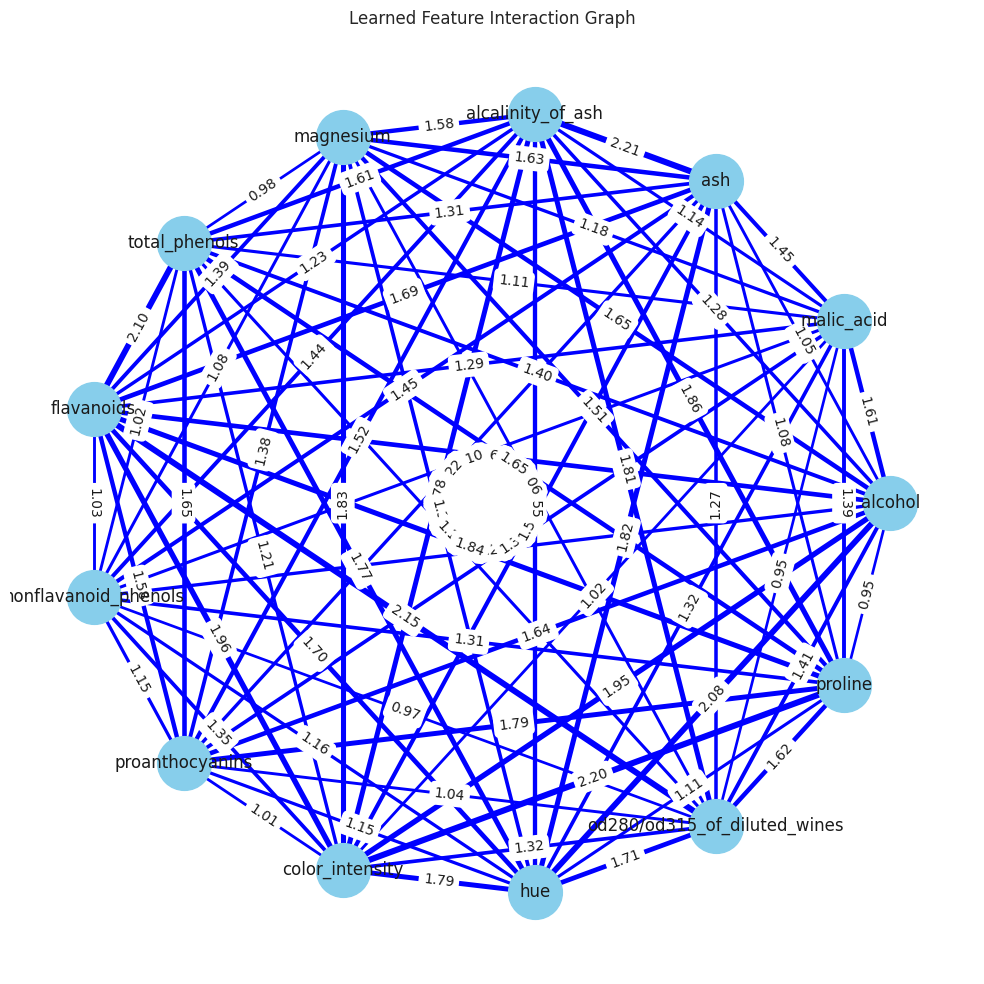

In [10]:
display(Markdown("#### `plot_feature_interaction_graph`"))
display(Markdown("Creates a graph where nodes are input features and edges represent an important learned comparison. This provides a clear, high-level map of the model's logic. Requires `networkx`."))

fig, ax = plt.subplots(figsize=(10, 10))
try:
    plot_feature_interaction_graph(
        pdn_model.pairwise_diff_layer,
        feature_names=feature_names,
        ax=ax,
        threshold=0.5 # Show only strong interactions
    )
    plt.show()
except ImportError:
    display(Markdown("_`networkx` is not installed. Skipping this plot._"))

#### `plot_final_layer_contributions`

For a single sample (true class: 0), this function calculates which features *entering the final layer* had the most impact on the prediction. A positive contribution pushed the score towards the predicted class, while a negative one pushed it away.

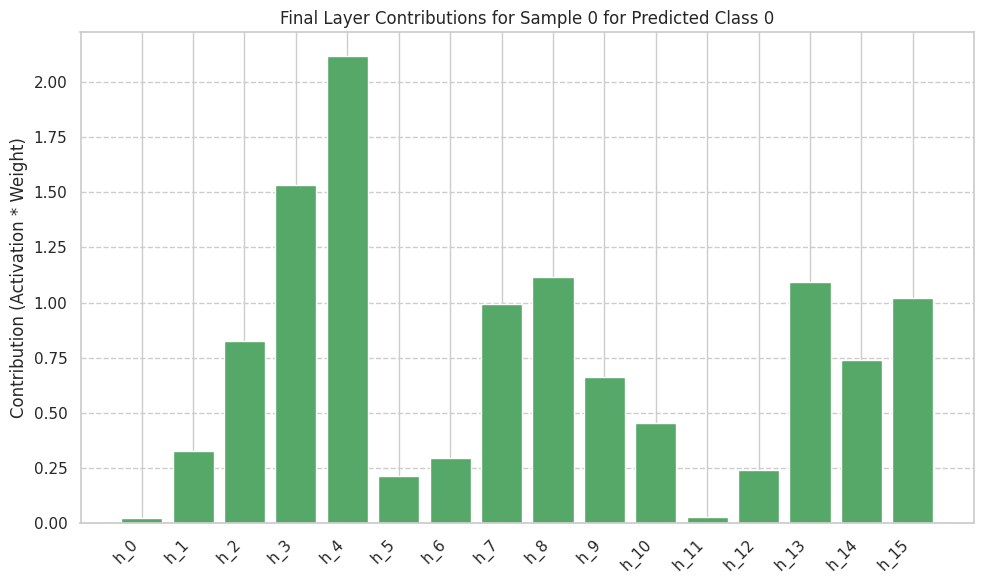

In [11]:
# Prepare a sample for single-instance explanations
sample_idx = 0
x_sample_tensor_std = torch.tensor(X_test_std[sample_idx], dtype=torch.float32).to(DEVICE)
x_sample_tensor_pos = torch.tensor(X_test_pos[sample_idx], dtype=torch.float32).to(DEVICE)
true_label = y_test_std[sample_idx]

display(Markdown("#### `plot_final_layer_contributions`"))
display(Markdown(f"For a single sample (true class: {true_label}), this function calculates which features *entering the final layer* had the most impact on the prediction. A positive contribution pushed the score towards the predicted class, while a negative one pushed it away."))

fig, ax = plt.subplots(figsize=(10, 6))
plot_final_layer_contributions(
    irn_model_diff,
    x_sample_tensor_std,
    feature_names=[f"h_{i}" for i in range(irn_model_diff.rune_blocks[0].gated_agg.dim)],
    ax=ax,
    title=f"Final Layer Contributions for Sample {sample_idx}"
)
plt.show()

### 4.4. Rule and Path Tracing
These functions produce textual or dictionary-based reports of the model's reasoning process. Here we compare the reports for different `interaction_type`s.

In [12]:
display(Markdown("#### `trace_decision_path` for `interaction_type='difference'`"))
display(Markdown("The most powerful function. It provides a complete, step-by-step reasoning trace for a prediction. Note that the dominant terms are of the form `(h_i - h_j)`."))

path_report_irn_diff = trace_decision_path(irn_model_diff, x_sample_tensor_std, top_k=2)
print(json.dumps(path_report_irn_diff, indent=2))

#### `trace_decision_path` for `interaction_type='difference'`

The most powerful function. It provides a complete, step-by-step reasoning trace for a prediction. Note that the dominant terms are of the form `(h_i - h_j)`.

{
  "InputProjection": "Input projected to internal dimension.",
  "RUNEBlock_0": {
    "DominantTropicalTerms": {
      "Proj_0": [
        [
          "(Proj_0 - Proj_6)",
          0.07178855687379837
        ],
        [
          "(Proj_0 - Proj_15)",
          0.06930873543024063
        ]
      ],
      "Proj_1": [
        [
          "(Proj_1 - Proj_10)",
          0.07514619082212448
        ],
        [
          "(Proj_1 - Proj_6)",
          0.0743367001414299
        ]
      ],
      "Proj_2": [
        [
          "(Proj_2 - Proj_6)",
          0.0817141979932785
        ],
        [
          "(Proj_2 - Proj_15)",
          0.07077087461948395
        ]
      ],
      "Proj_3": [
        [
          "(Proj_3 - Proj_7)",
          0.07046622037887573
        ],
        [
          "(Proj_3 - Proj_2)",
          0.06819703429937363
        ]
      ],
      "Proj_4": [
        [
          "(Proj_4 - Proj_10)",
          0.07214121520519257
        ],
        [
          "(P

In [13]:
display(Markdown("#### `trace_decision_path` for `interaction_type='log_ratio'`"))
display(Markdown("Now we apply the same function to the model trained on log-ratios. The dominant terms now reflect ratio comparisons, e.g., `log(h_i) - log(h_j)`."))

path_report_irn_log_ratio = trace_decision_path(irn_model_log_ratio, x_sample_tensor_pos, top_k=2)
print(json.dumps(path_report_irn_log_ratio, indent=2))

#### `trace_decision_path` for `interaction_type='log_ratio'`

Now we apply the same function to the model trained on log-ratios. The dominant terms now reflect ratio comparisons, e.g., `log(h_i) - log(h_j)`.

{
  "InputProjection": "Input projected to internal dimension.",
  "RUNEBlock_0": {
    "DominantTropicalTerms": {
      "Proj_0": [
        [
          "(log(Proj_0) - log(Proj_6))",
          0.06696686148643494
        ],
        [
          "(log(Proj_0) - log(Proj_10))",
          0.066844642162323
        ]
      ],
      "Proj_1": [
        [
          "(log(Proj_1) - log(Proj_14))",
          0.06873492896556854
        ],
        [
          "(log(Proj_1) - log(Proj_8))",
          0.06869721412658691
        ]
      ],
      "Proj_2": [
        [
          "(log(Proj_2) - log(Proj_1))",
          0.06899214535951614
        ],
        [
          "(log(Proj_2) - log(Proj_0))",
          0.06804932653903961
        ]
      ],
      "Proj_3": [
        [
          "(log(Proj_3) - log(Proj_4))",
          0.07893174141645432
        ],
        [
          "(log(Proj_3) - log(Proj_5))",
          0.07095443457365036
        ]
      ],
      "Proj_4": [
        [
          "(log(P

In [14]:
display(Markdown("#### `trace_decision_path` for `interaction_type='ratio'`"))
display(Markdown("And finally, for the model working with direct ratios. The dominant terms now represent `h_i / h_j`."))

path_report_irn_ratio = trace_decision_path(irn_model_ratio, x_sample_tensor_pos, top_k=2)
print(json.dumps(path_report_irn_ratio, indent=2))

#### `trace_decision_path` for `interaction_type='ratio'`

And finally, for the model working with direct ratios. The dominant terms now represent `h_i / h_j`.

{
  "InputProjection": "Input projected to internal dimension.",
  "RUNEBlock_0": {
    "DominantTropicalTerms": {
      "Proj_0": [
        [
          "(Proj_0 / Proj_4)",
          0.06777333468198776
        ],
        [
          "(Proj_0 / Proj_11)",
          0.06759430468082428
        ]
      ],
      "Proj_1": [
        [
          "(Proj_1 / Proj_5)",
          0.0672881081700325
        ],
        [
          "(Proj_1 / Proj_6)",
          0.06713805347681046
        ]
      ],
      "Proj_2": [
        [
          "(Proj_2 / Proj_7)",
          0.06716381013393402
        ],
        [
          "(Proj_2 / Proj_5)",
          0.06687603890895844
        ]
      ],
      "Proj_3": [
        [
          "(Proj_3 / Proj_4)",
          0.0688580870628357
        ],
        [
          "(Proj_3 / Proj_11)",
          0.06718283146619797
        ]
      ],
      "Proj_4": [
        [
          "(Proj_4 / Proj_7)",
          0.06775778532028198
        ],
        [
          "(Pro

### 4.5. Interpreting `PrototypeRuneNet`
This model type has its own specialized, highly intuitive interpretation methods focused on case-based reasoning.

#### `plot_prototypes_with_tsne`

Visualizes the learned prototype 'cases' (red 'X's) in the same 2D space as the real data points. This helps us understand if the model has learned meaningful archetypes that are representative of the data clusters.

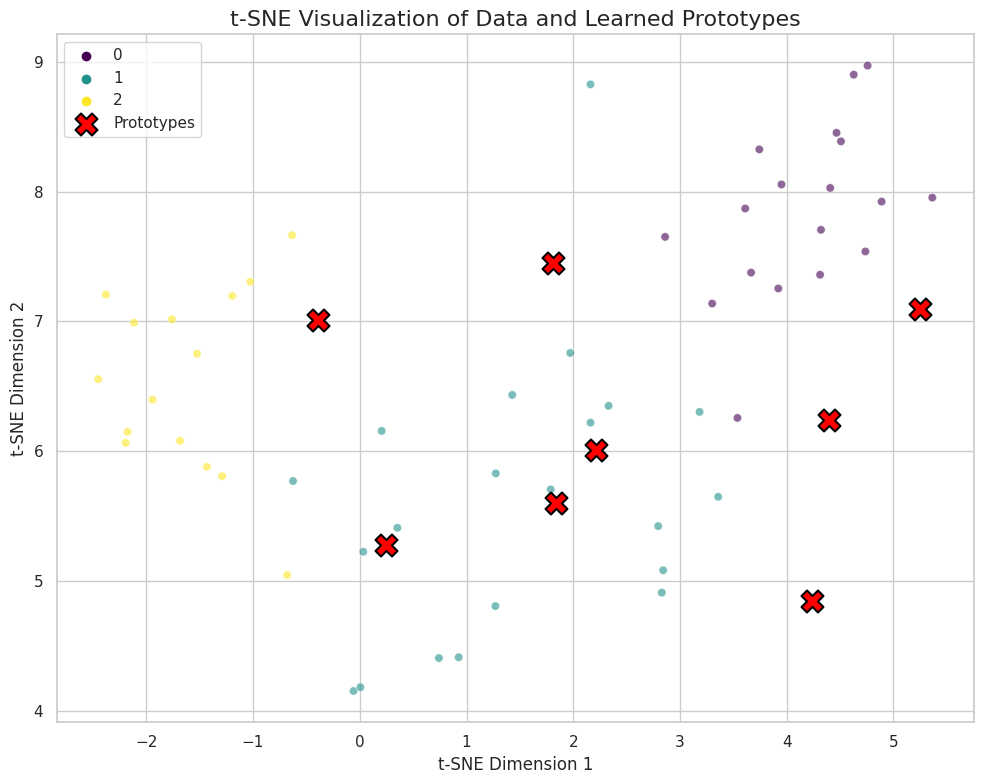

In [15]:
display(Markdown("#### `plot_prototypes_with_tsne`"))
display(Markdown("Visualizes the learned prototype 'cases' (red 'X's) in the same 2D space as the real data points. This helps us understand if the model has learned meaningful archetypes that are representative of the data clusters."))

fig, ax = plt.subplots(figsize=(10, 8))
plot_prototypes_with_tsne(proto_model, X_test_std, y_test_std, ax=ax)
plt.show()

#### `analyze_prototype_prediction`

Provides a detailed breakdown of a single prediction. It shows which prototype the sample was most similar to and gives a feature-by-feature comparison between the sample and that 'ideal case'.

**Sample Analysis**
- True Class: `0`
- Predicted Class: `0`

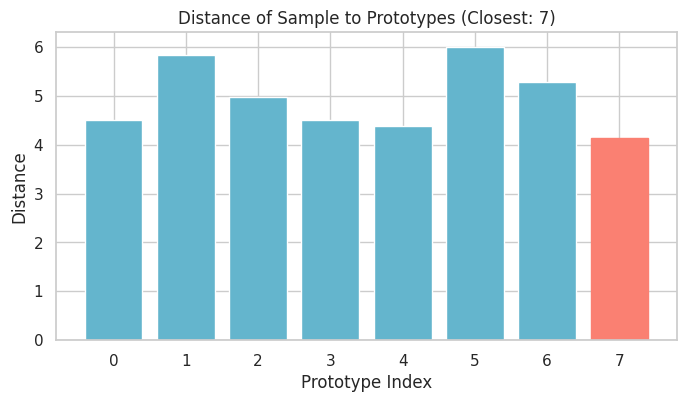

**Feature Comparison with Closest Prototype (7)**

,Feature,Prototype_Value,Sample_Value
0,alcohol,1.276304,0.252582
1,malic_acid,0.590468,0.069135
2,ash,-1.096166,1.143582
3,alcalinity_of_ash,0.387985,-0.316772
4,magnesium,0.368498,0.063252
5,total_phenols,0.315197,0.811689
6,flavanoids,1.784202,1.296041
7,nonflavanoid_phenols,0.480968,-0.511472
8,proanthocyanins,0.091882,2.089053
9,color_intensity,1.898862,0.289153


In [16]:
display(Markdown("#### `analyze_prototype_prediction`"))
display(Markdown(f"Provides a detailed breakdown of a single prediction. It shows which prototype the sample was most similar to and gives a feature-by-feature comparison between the sample and that 'ideal case'."))

# Use the same sample as before
analysis_report_proto = analyze_prototype_prediction(
    proto_model,
    torch.tensor(X_test_std[sample_idx], dtype=torch.float32),
    feature_names=feature_names,
    top_k=1
)

pred_class = analysis_report_proto['prediction']
display(Markdown(f"**Sample Analysis**\n- True Class: `{true_label}`\n- Predicted Class: `{pred_class}`"))

# Show distances
closest_idx = analysis_report_proto['closest_prototypes'][0]['index']
plt.figure(figsize=(8, 4))
plt.bar(range(len(analysis_report_proto['distances'])), analysis_report_proto['distances'], color='c')
plt.gca().get_children()[closest_idx].set_color('salmon')
plt.title(f"Distance of Sample to Prototypes (Closest: {closest_idx})")
plt.xlabel("Prototype Index")
plt.ylabel("Distance")
plt.show()

# Show feature comparison dataframe
display(Markdown(f"**Feature Comparison with Closest Prototype ({closest_idx})**"))
display(analysis_report_proto['closest_prototypes'][0]['feature_comparison'].style.bar(align='mid', color=['#d65f5f', '#5fba7d']))

In [17]:
display(Markdown("#### `trace_decision_path` (PrototypeRuneNet Dispatch)"))
display(Markdown("As a final demonstration, we show that `trace_decision_path` correctly dispatches to the prototype analysis when given a `PrototypeRuneNet`."))

# This call will internally use `analyze_prototype_prediction`
path_report_proto = trace_decision_path(
    proto_model,
    torch.tensor(X_test_std[sample_idx], dtype=torch.float32),
    feature_names=feature_names,
    top_k=1
)

# We don't print the whole thing again, just confirm it worked
print("Report generated successfully. Keys:", list(path_report_proto.keys()))
assert 'closest_prototypes' in path_report_proto

#### `trace_decision_path` (PrototypeRuneNet Dispatch)

As a final demonstration, we show that `trace_decision_path` correctly dispatches to the prototype analysis when given a `PrototypeRuneNet`.

Dispatching to `analyze_prototype_prediction` for PrototypeRuneNet.
Report generated successfully. Keys: ['prediction', 'distances', 'closest_prototypes']


---
## Conclusion

This notebook has demonstrated every key interpretation function in the `rune` library. We've seen how to visualize individual layers, analyze the inner workings of RUNE blocks, trace complete decision paths for different model types, and perform intuitive case-based analysis for `PrototypeRuneNet`. This comprehensive toolkit makes RUNE a powerful choice for applications where transparency and understandability are paramount.